# KNN baseline for Azure VM criticality

This notebook trains a K-Nearest Neighbors classifier using **arrival-time-safe** features only (static config + tenant history + request time).

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
)

# Paths
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH = DATA_DIR / "vm_val.parquet"
TEST_PATH = DATA_DIR / "vm_test.parquet"
TARGET_COL = "critical"


In [2]:
# 1) Load data splits
print("Loading split files...")
df_train = pl.read_parquet(TRAIN_PATH)
df_val = pl.read_parquet(VAL_PATH)
df_test = pl.read_parquet(TEST_PATH)

print(f"Train rows: {df_train.height}")

Loading split files...
Train rows: 632426


In [3]:
# 2) Arrival-time-safe feature list
# -----------------------------------------------------------------------------
# Timing
feat_timing = [
    "day_idx",
    "hour_of_day",
    "ts_vm_created",
    "ts_first_vm_created",
]

# Static VM config & deployment metadata
feat_static = [
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour",
]

# Tenant history (safe) derived only from earlier VMs
feat_history = [c for c in df_train.columns if c.startswith("hist_")]

# Categorical
feat_categorical = ["vm_category"]

SAFE_NUMERIC_COLS = feat_timing + feat_static + feat_history
SAFE_CATEGORICAL_COLS = feat_categorical
ALL_SAFE_FEATURES = SAFE_NUMERIC_COLS + SAFE_CATEGORICAL_COLS

print(f"Total features: {len(ALL_SAFE_FEATURES)}")

Total features: 23


In [4]:
# 3) Prepare X/y helper
def get_X_y(df_polars):
    X = df_polars.select(ALL_SAFE_FEATURES).to_pandas()
    y = df_polars.select(TARGET_COL).to_pandas().values.ravel()
    return X, y

X_train, y_train = get_X_y(df_train)
X_val, y_val = get_X_y(df_val)
X_test, y_test = get_X_y(df_test)

In [5]:
# 4) Preprocess + model pipeline
# -----------------------------------------------------------------------------
# KNN is distance-based, so scaling numeric columns is essential.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, SAFE_NUMERIC_COLS),
        ("cat", categorical_transformer, SAFE_CATEGORICAL_COLS),
    ]
)

# Baseline KNN (can tune neighbors/weights/metric later)
knn = KNeighborsClassifier(
    n_neighbors=50,
    weights="distance",  # distance weighting often helps with class imbalance
    metric="minkowski",
    p=2,
    n_jobs=-1,
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", knn),
    ]
)

Training KNN...
Done.
--- Validation (threshold=0.406) ---
              precision    recall  f1-score   support

           0      0.853     0.798     0.824     90628
           1      0.595     0.682     0.636     39377

    accuracy                          0.763    130005
   macro avg      0.724     0.740     0.730    130005
weighted avg      0.774     0.763     0.767    130005

AUC-PR: 0.7047 | AUC-ROC: 0.8188


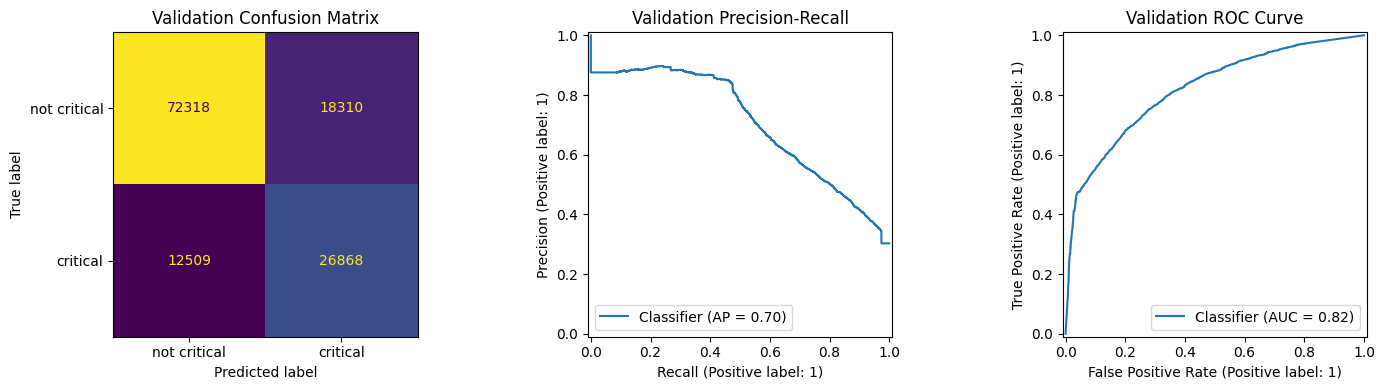

--- Test (threshold=0.406) ---
              precision    recall  f1-score   support

           0      0.823     0.750     0.785     89173
           1      0.560     0.664     0.607     42676

    accuracy                          0.722    131849
   macro avg      0.692     0.707     0.696    131849
weighted avg      0.738     0.722     0.728    131849

AUC-PR: 0.6831 | AUC-ROC: 0.7829


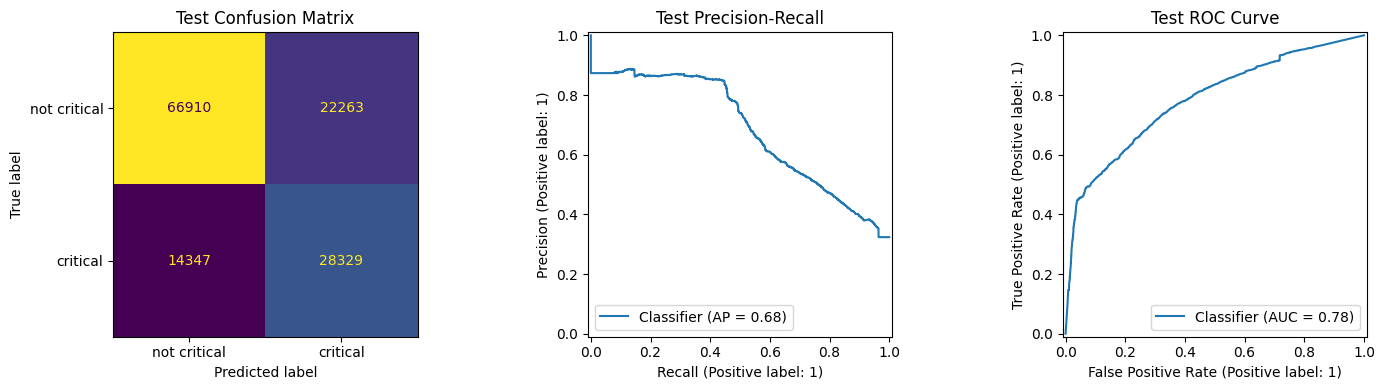

In [6]:
# 5) Train and evaluate (aligned with RF notebook output)
# -----------------------------------------------------------------------------
print("Training KNN...")
model.fit(X_train, y_train)
print("Done.")

def evaluate_split(model, X, y, split_name: str, threshold: float = 0.5) -> dict:
    # Print metrics (report, ROC/PR AUC, confusion) and plot confusion + curves.
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)
    auc_pr = average_precision_score(y, proba)
    auc_roc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, preds)

    print(f"--- {split_name} (threshold={threshold:.3f}) ---")
    print(classification_report(y, preds, digits=3, zero_division=0))
    print(f"AUC-PR: {auc_pr:.4f} | AUC-ROC: {auc_roc:.4f}")

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ConfusionMatrixDisplay(cm, display_labels=["not critical", "critical"]).plot(ax=axes[0], colorbar=False)
    axes[0].set_title(f"{split_name} Confusion Matrix")
    PrecisionRecallDisplay.from_predictions(y, proba, ax=axes[1])
    axes[1].set_title(f"{split_name} Precision-Recall")
    RocCurveDisplay.from_predictions(y, proba, ax=axes[2])
    axes[2].set_title(f"{split_name} ROC Curve")
    plt.tight_layout()
    plt.show()

    return {"auc_pr": auc_pr, "auc_roc": auc_roc, "confusion": cm.tolist()}

# Tune a threshold on val (F1) to mirror RF notebook
proba_val = model.predict_proba(X_val)[:, 1]
candidates = np.linspace(0.01, 0.5, 200)
best_threshold = max(candidates, key=lambda t: f1_score(y_val, (proba_val >= t).astype(int)))

metrics_val = evaluate_split(model, X_val, y_val, "Validation", threshold=best_threshold)
metrics_test = evaluate_split(model, X_test, y_test, "Test", threshold=best_threshold)
